Classification de textes : identification de la langue
============================

La plupart de ces notebooks peuvent tourner sans acceleration GPU. Vous pouvez utiliser Google Colab ou installer jupyter-notebook sur votre ordinateur. Pytorch est déjà installé sur Colab, par contre il faut suivre https://pytorch.org/get-started/locally/ en local.


In [1]:
## example de deploiement local (pas besoin de refaire si vous avez déjà fait lors du TP1)
# virtualenv -ppython3.8 pstaln-env
# source pstaln-env/bin/activate
# pip3 install torch==1.10.0+cpu -f https://download.pytorch.org/whl/cpu/torch_stable.html
# pip3 install matplotlib ipykernel
# python3 -m ipykernel install --user --name=pstaln-env
# jupyter-notebook
## puis sélectionner le noyeau pstaln-evn

Notre objectif aujourd'hui est d'effectuer une classification de textes assez simple : étant donné un bout de texte, on voudrait prédire dans quelle langue ce texte a été écrit. Par exemple :

$model(\text{"Vamos a la playa"}) = \text{ES}\\
model(\text{"Je vois la vie en rose"}) = \text{FR}\\
model(\text{"Ich hab den Farbfilm vergessen"}) = \text{DE}$

Les codes ES, FR et DE sont les [codes ISO-639-2](https://www.loc.gov/standards/iso639-2/php/code_list.php) des langues espagnol, français et allemand. Nous travaillerons dans ce TP sur des langues européennes.

### Datasets

Nous allons utiliser un dataset contenant des petits bouts de texte annotés avec le code de la langue. D'abord, téléchargeons le dataset qui a été préparé pour ce TP. Ce dataset provient d'un sujet de projet donné aux étudiant.e.s de L3 en informatique ([détails ici](https://wikitalep.lis-lab.fr/doku.php?id=projets-l3:langid)).

In [2]:
%%bash
if [ ! -d dataset-european/ ]; then
  wget -q -O dataset-european.tar.gz https://pageperso.lis-lab.fr/carlos.ramisch/download_files/pstaln/dataset-european.tar.gz
  tar xfz dataset-european.tar.gz 
  rm dataset-european.tar.gz
fi
ls dataset-european

european-dev.txt
european-test-ref.txt
european-test.txt
european-train.txt


Aussi, comme d'habitude, on importe les sous-modules de pytorch et d'autres modules python utiles dans ce TP.

In [3]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import random

Dans chacun des fichiers texte du dataset (UTF-8, CR-LF), se trouve une liste de petits documents (une ou deux phrases la plupart du temps) suivis d'une tabulation, suivis du code de la langue à reconnaître (sauf dans le fichier `test`, où la langue n'est pas donnée, en mode `blind` d'une campagne d'évaluation). Nous pouvons ouvrir le fichier `train` pour faire quelques statistiques sur les données d'apprentissage.

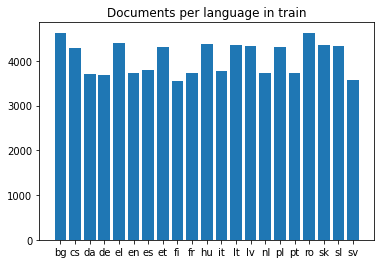

Total nb. languages: 21
Total nb. documents: 85301


In [4]:
def opendataset(filename):
    """
    returns a list of X input texts paired wiht a list of Y output language labels
    """
    X = []; Y = []
    with open(filename) as datasetfile:
        for line in datasetfile :
            (x,y) = line.strip().split("\t")
            X.append(x); Y.append(y)
    return (X,Y)

(trainXtexts, trainYlabels) = opendataset("dataset-european/european-train.txt")
#showhistograms(trainX, trainY)
hist=Counter(trainYlabels)
plt.title("Documents per language in train")
plt.bar(hist.keys(),hist.values()); 
plt.show()
print("Total nb. languages: {}".format(len(hist)))
print("Total nb. documents: {}".format(len(trainXtexts)))

Cette base contient une grande quantité de documents par langue. Pour rendre les calculs plus rapides sur ce notebook, nous garderons un peu moins de 10% des textes. Si vous faites des expériences en local, vous pouvez conserver la totalité de la base.

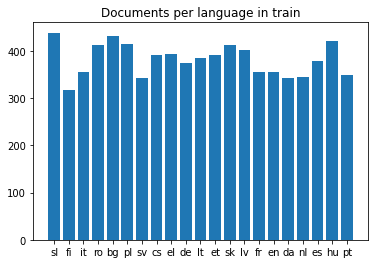

Total nb. languages: 21
Total nb. documents: 8000


In [5]:
random.seed(5)
trainXtexts,trainYlabels = map(list,zip(*(random.sample(list(zip(trainXtexts,trainYlabels)),k=8000))))
hist=Counter(trainYlabels)
plt.title("Documents per language in train")
plt.bar(hist.keys(),hist.values()); 
plt.show()
print("Total nb. languages: {}".format(len(hist)))
print("Total nb. documents: {}".format(len(trainXtexts)))

### Définition des features

La tâche d'identification de la langue est une tâche très simple, pour laquelle il est possible d'apprendre des modèles assez performants avec assez peu de features et de données d'entraînement. C'est pour cela que cette tâche est idéale pour commencer à effectuer des expériences avec pytorch sur le texte.

La première chose à faire consiste à définir les features. Pour cela, nous allons nous concentrer sur les n-grammes de caractères, c'est-à-dire, les séquences de _n_ caractères dans un texte. Nous allons commencer avec $n=2$, donc des _bigammes_ de caractères.

Voici un exemple d'une fonction qui estrait les n-grammes de caractères à partir d'une liste de textes. Le paramètre `n` détermine la longueur des n-grammes ; le paramètre `pad` permet d'activer un désactiver le padding, c'est-à-dire, l'insertion d'un caractère spécial pour marquer le début (`<`) et la fin (`>`) d'un texte ; le paramètre `lower` permet d'activer ou désactiver la transformation de tout le texte en minuscules avant toute extraction. On commence à voir une serie de pré-traitements nécessaires pour traiter le texte, tels que le padding et le traitement des majuscules/minuscules.

In [6]:
def get_ngrams(texts, n=2, pad=True, lower=True):
    """
    Given a list of texts, returns a list of its n-grams in order of occurrence.    
    """
    ngrams = []
    for text in texts :
        if pad : # Padding -> add special beginning and end markers
            text = "<" + text + ">"
        if lower : # Lowercase all text before extracting n-grams
            text = text.lower()
        for i in range(len(text) - n + 1):
            ngrams.append(text.replace(" ","_")[i:i + n]) # Space replaced by underscore
    return ngrams

# testez en variant les valeurs de n, pad, lower
ngrams_toy = get_ngrams(["abcd ABCD"],n=2,pad=True,lower=True)
print(ngrams_toy) 
print(Counter(ngrams_toy))

['<a', 'ab', 'bc', 'cd', 'd_', '_a', 'ab', 'bc', 'cd', 'd>']
Counter({'ab': 2, 'bc': 2, 'cd': 2, '<a': 1, 'd_': 1, '_a': 1, 'd>': 1})


Il nous faut maintenant une liste des bigrammes de caractères les plus fréquents par langue. Pour cela, nous allons regrouper les textes dans un dictionnaire dont les clés sont les codes de langue et les valeurs sont des listes de textes.

In [7]:
textsperlang = defaultdict(list)
for (x,y) in zip(trainXtexts,trainYlabels) :
    textsperlang[y].append(x)
textsperlang["fr"][10]

'Je donne la parole à M. le président en exercice du Conseil.'

Le dictionnaire `textsperlang` contient désormais tous les textes d'entraînement regroupés par langue. Nous allons maintenant créer un ensemble de features (ou vocabulaire), constitué de l'union des N bigrammes les plus fréquents par langue. Pour aller plus vite, nous allons utiliser uniquement les 300 premiers textes de chaque langue pour extraire ces features, cela devrait suffire pour avoir un échantillon représentatif.

In [8]:
N=100 # retain N most frequent n-grams per language
n=2   # size of n-gram is 2
# You can play with these parameters later to see how they influence the predictions
    
vocab = set([])
for lang in textsperlang.keys() :
    freq_ngrams = Counter(get_ngrams(textsperlang[lang][:300],n=n)).most_common(N)    
    vocab = vocab | set(map(lambda x:x[0],freq_ngrams))
    #print(lang, freq_ngrams[:5]) # Uncomment if you want to see most common n-grams per lang

vocab = list(vocab)
print("Feature vocabulary: {}...".format(vocab[:10]))
print("Number of features: {}".format(len(vocab)))

Feature vocabulary: ['ke', 'ri', 'ι_', '_г', 'nu', 'kö', 'jā', 'от', 'ου', 'ис']...
Number of features: 551


### Représentation one-hot

Nous allons maintenant passer à l'étape de création du classifieur MLP avec pytorch. Pour cela, il faudra représenter chaque texte sous la forme d'un vecteur qui est à la fois utile pour notre tâche et traitable dans un modèle de ce type. 

La première approche consiste à représenter chaque ngramme de caractères sous la forme d'un vecteur _one-hot_, c'est-à-dire, un vecteur de 552 positions constitué uniquement de zéros, sauf à une position _i_ correspondant au n-gramme de caractères représenté. 

$$x \in \mathbb{R}^{552}, x{[i]} = \begin{cases}1&\text{si c'est le i-ème n-gramme}\\0&\text{sinon}\end{cases}$$

Cela veut dire que chaque n-gramme sera associé à un indice $i$ du vecteur $x$. Cependant, notez que le nombre de features peut vite exploser. Par exemple, un texte contenant 1000 n-grammes sera représenté par une suite de $552\times 1000 = 552000$ features.

De plus, comme chaque texte contient un nombre variable de caractères et donc de n-grammes, il faudra trouver une astuce pour que toutes les entrées du réseau aient la même longueur. Il est possible de faire cela avec du padding (que nous verrons plus tard) mais pour le moment, nous allons adopter une stratégie plus simple, qui consiste à faire un "sac de n-grammes" (la version la plus connue de ce type d'approche s'appelle "sac de mots" ou "bag of words" en anglais).

Ainsi, notre représentation du document $D$ ignorera l'ordre dans lequel les n-grammes apparaissent, mais représentera uniquement l'apparition du n-gramme dans le document :

$$d \in \mathbb{R}^{552}, d{[i]} = \begin{cases}1&\text{si $D$ contient le n-gramme}~i\\0&\text{sinon}\end{cases}$$

In [9]:
def get_onehot(features,vocab):
    """
    Create a one-hot torch tensor of dimension `len(vocab)` with ones at positions present in `features`
    `vocab` is the list of all possible features, position in list encodes feature index
    """
    onehot =  torch.zeros(len(vocab))
    for (i,feat) in enumerate(vocab) :
        if feat in features :
            onehot[i] = 1.0
    return onehot

print(get_onehot(set(get_ngrams(["le monde est grand"])),vocab))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

Afin d'accélérer les calculs plus tard, nous allons sauvegarder, pour chaque document, son histogramme de n-grammes de caractères. Ensuite, nous passons la liste de n-grammes présents dans le document pour l'encodage one-hot. Cette étape peut prendre un peu de temps...

In [10]:
trainXngrams = [get_ngrams([x]) for x in trainXtexts]
print(list(trainXngrams[0])[:5],"->",trainYlabels[0])

trainX = torch.stack([get_onehot(set(x),vocab) for x in trainXngrams])
print(trainX[0,:10])
print(trainX.shape)
print(trainX.type())

['<t', 'tr', 're', 'et', 'tj'] -> sl
tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
torch.Size([8000, 551])
torch.FloatTensor


Pour notre classifieur multi-classes, il faudra également encoder chaque langue sous la forme d'un indice entier. Nous allons donc créer un dictionnaire qui renvoie un entier pour chaque code de langue, et ensuite appliquer la transformation pour obtenir `Y` :

In [11]:
langs = list(textsperlang.keys())
lang2id = {lang:i for (i,lang) in enumerate(langs)}
id2lang = {i:lang for (i,lang) in enumerate(langs)}

trainY = torch.tensor([lang2id[y] for y in trainYlabels])
print(trainY[:10])
print(trainY.shape)
print(trainY.type())

tensor([0, 1, 2, 3, 4, 5, 1, 6, 7, 8])
torch.Size([8000])
torch.LongTensor


### Classifieur

Nos données sont désormais prêtes. Nous allons apprendre un classifieur très simple, composé d'une transformation linéaire de nos vecteurs $x$ dimension 552, vers un vecteur de dimension 21 représentant les langues, puis d'un softmax sur ces derniers (inclus dans la loss). Voyons déjà ce que ce modèle sera capable de faire.

In [12]:
from torch.utils.data import TensorDataset, DataLoader
train_set = TensorDataset(trainX, trainY)
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)

class SimpleModel(nn.Module):
    def __init__(self,dimX,dimY):
        super().__init__()
        self.layer1 = nn.Linear(dimX, dimY)
    def forward(self, x):
        return self.layer1(x)
    
langIDv1 = SimpleModel(len(vocab),len(langs))

Pour la fonction d'apprentissage, nous utiliserons la même que celle du TP précédant. Voyons ce que ça donne...

In [13]:
def fit(model, epochs, train_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(epochs):
        total_loss = 0; num = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            y_scores = model(x)  
            loss = criterion(y_scores, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num += len(y)
        if epoch % (epochs // 10) == 0:
            print(epoch, total_loss / num)
            
fit(langIDv1,20,train_loader)

0 0.057755003814352675
2 0.0034132687800665735
4 0.0012113664920607335
6 0.0005010913811964883
8 0.0002298640650243442
10 0.00011539934953624708
12 6.350934430631128e-05
14 3.78047396104062e-05
16 2.352396462466022e-05
18 1.4902860520004336e-05


Que vaut ce classifieur ? Pour l'évaluer, on peut prédire la langue des textes de l'ensemble de développement (ou validation), et calculer le taux de succès (_accuracy_ ou exactitude). Pour cela, nous allons créer une fonction `predict` qui prédit la langue d'une liste de textes. Notez la ligne `model.eval()` -- elle permet de mettre le modèle en mode évaluation, par exemple, pour ne pas appliquer de dropout si il y en a. Le modèle est remis en mode train à la fin.

In [14]:
def predict(model, texts, vocab, id2lang):
    model.eval()
    ngrams = [get_ngrams([x]) for x in texts]    
    X = torch.stack([get_onehot(set(x), vocab) for x in ngrams])
    Yhat = torch.max(model(X),1)[1]
    model.train()
    return [id2lang[y.item()] for y in Yhat]

def accuracy(predict,ref):
    return sum([1 if y == yhat else 0 for (yhat,y) in zip(predict,ref)])/len(ref)

pred = predict(langIDv1,["Vamos a la playa","je vois la vie en rose","Ich hab den Farbfilm vergessen"],vocab,id2lang)
print(pred)
print(accuracy(pred,["es","fr","de"]))

['es', 'fr', 'de']
1.0


C'est un premier résultat prometteur. Voyons le résultat sur la totalité du dev.

In [15]:
(devXtexts, devYlabels) = opendataset("dataset-european/european-dev.txt")

pred=predict(langIDv1,devXtexts,vocab,id2lang)
print("accuracy {:.4f}".format(accuracy(pred,devYlabels)))

accuracy 0.9810


Wow, impressionnant ! Un modèle très simple est capable d'identifier la langue des textes avec une exactitude d'environ 98%. On pourrait rendre la tâche artificiellement plus dûre. Pour cela, nous pouvons garder uniquement les 15 premiers caractères de notre texte, car il est beaucoup plus difficile de prédire la langue d'un texte court.

In [16]:
devXtextshard = [x[:15] for x in devXtexts]
pred = predict(langIDv1, devXtextshard, vocab, id2lang)
print("accuracy {:.4f}".format(accuracy(pred,devYlabels)))

accuracy 0.8254


### Classifieur MLP avec embeddings

Une alternative plus souple aux représentations one-hot est la représentation de chaque n-gramme de caractères comme un vecteur dense de plus petite dimension (par exemple, 50 au lieu de 552). Ce vecteur, noté $e(D[i])$ pour le n-gramme correspondant à la position $i$ du document $D$, est initialisé aléatoirement et ses poids sont ajustés lors de l'entraînement. Pour représenter un document, nous allons procéder de manière similaire, en calcular un vecteur moyen des bigrammes contenus dans le document $D$ :

$$d \in \mathbb{R}^{50}, d = \frac{1}{|D|}\sum_{i=1}^{|D|} e(D[i])$$

Notez que dans cette représentation, une information supplémentaire est implicitement représentée : la fréquence d'occurrence de chaque n-gramme dans le document. Plus un n-gramme est fréquent dans le document, plus son poids augment dans la moyenne.

Pour implémenter cette stratégie, nous pouvons utiliser la couche `nn.Embedding` de pytorch. Elle prend en entrée deux paramètres : la taille du vocabulaire et la dimension des embeddings. Lors de la prédiction, elle renvoie les embeddings correspondant à une liste d'indices donnés en entrée.

In [17]:
embed_dim = 50

class LinearModelEmbed(nn.Module):
    def __init__(self,dimX,dimY):
        super().__init__()
        self.embed = nn.Embedding(dimX,embed_dim)        
        self.layer1 = nn.Linear(embed_dim, dimY)
    def forward(self, x):
        embedded = self.embed(x)              # convert each n-gram index into 50-d vector
        combined = torch.mean(embedded,dim=0) # average embeddings for the whole document
        return self.layer1(combined)
    
langIDv2 = LinearModelEmbed(len(vocab)+1,len(langs)) # len(vocab)+1 pour prendre en compte le padding

Il sera aussi nécessaire de transformer nos entrées : au lieu d'avoir un tenseur avec des représentations one-hot, chaque document doit maintenant être représenté par une liste d'indices correspondant aux bigrammes qu'il contient. Pour cela, nous allons utiliser un `LongTensor`. En raison de l'entraînement par batches, il faudra couper les textes pour qu'ils ne dépassent pas une longueur maximale. De même, nous utiliserons le symbole spécial `0` pour représenter le padding, c'est-à-dire, pour remplir la séquence si elle contient moins de `seq_max_len` mots.

In [18]:
seq_max_len = 128
bigram2id = {bigram:i+1 for (i,bigram) in enumerate(vocab)}    

def get_indices(features, bigram2id):
    """
    Create a Long tensor of dimension `seq_max_len` with indices of features in vocab
    """
    indices = torch.zeros(seq_max_len) 
    indices_pos = 0
    for k in features :
        if k in bigram2id.keys() :
            indices[indices_pos] = bigram2id[k]
            indices_pos += 1
            if indices_pos == seq_max_len : 
                break # cut sentence here
    if len(indices) < seq_max_len :
        indices = indices + [0 * (seq_max_len-len(indices))]
    return indices.long()

trainX = torch.stack([get_indices(x,bigram2id) for x in trainXngrams])
print(trainX[0])
print(trainX.shape)

tensor([353, 395,  28,  43, 273, 389,  53,  24, 232,  88,  78, 417,  86, 108,
        292,  48, 273, 201, 143, 333, 480, 489,  30, 450,   2, 176, 108, 523,
        341, 544,  24, 542, 168, 317, 368,  14, 368, 278, 183, 351, 165,  99,
         59, 198, 317, 109, 207, 536, 337, 202, 460, 247,  24, 143, 154, 247,
         20, 309, 432,  30, 450, 210,  53,  20, 165,  99, 538,  30, 450, 395,
        232, 376, 232,  70,  84, 202, 368,  24,  28, 535,  78, 203, 411,  48,
        381, 508,  48, 304, 524, 504, 378, 247,  20, 423, 460, 246,  43, 264,
        428,  78,  82, 278,  48, 523,  24,  94, 376, 419, 388,  43, 315,   1,
        183,  25, 368, 403, 202, 523, 341, 470, 271,  28, 178, 536, 368, 305,
        450, 395])
torch.Size([8000, 128])


Entraînons maintenant ce modèle, mais cette fois-ci nous nous intéressons à la loss et à l'exactitude sur le jeu de validation tout au long de l'entraînement, pour avoir une idée de la courbe d'apprentissage sur le jeu de développement. Ainsi, nous créons une nouvelle fonction d'entraînement qui, toutes les 1/10 époques, calcule et affiche la loss et l'exactitude sur le jeu de développement.

In [19]:
def accuracy_and_loss(model, loader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    total_loss = correct = num = 0
    for x, y in loader:
        with torch.no_grad(): # no gradient needed
            y_scores = model(x)
            loss = criterion(y_scores, y)
            y_pred = torch.max(y_scores, 1)[1]
            correct += torch.sum(y_pred.data == y)
            total_loss += loss.item()
            num += len(y)
    model.train()
    return total_loss / num, correct.item() / num

def fit_curve(model, epochs, train_loader, dev_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(epochs):
        total_loss = 0; num = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            y_scores = model(x)  
            loss = criterion(y_scores, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num += len(y)
        if epoch % (epochs // 10) == 0:
            acc = accuracy_and_loss(model, dev_loader)
            template = "epoch {}, train-loss {}, val-loss {} val-accuracy {:.4f}"
            print(template.format(epoch, total_loss / num, *acc))

devY = torch.tensor([lang2id[y] for y in devYlabels])
devXngrams = [get_ngrams([x]) for x in devXtexts]
devX = torch.stack([get_onehot(x,bigram2id) for x in devXngrams])
dev_set = TensorDataset(devX, devY)
dev_loader = DataLoader(dev_set, batch_size=8)

fit_curve(langIDv1,20,train_loader, dev_loader)

epoch 0, train-loss 9.753850403538932e-06, val-loss 0.007925681402360761 val-accuracy 0.9841
epoch 2, train-loss 6.468906471771008e-06, val-loss 0.008608369242698347 val-accuracy 0.9810
epoch 4, train-loss 4.3512719995298936e-06, val-loss 0.009024225197127015 val-accuracy 0.9778
epoch 6, train-loss 2.875709556538486e-06, val-loss 0.009267665824098947 val-accuracy 0.9778
epoch 8, train-loss 1.8662878828860086e-06, val-loss 0.009667157958991725 val-accuracy 0.9778
epoch 10, train-loss 1.2612531721206688e-06, val-loss 0.01000777374142722 val-accuracy 0.9778
epoch 12, train-loss 8.055187451819767e-07, val-loss 0.009761317374908741 val-accuracy 0.9841
epoch 14, train-loss 5.137598807244404e-07, val-loss 0.010559997679343276 val-accuracy 0.9778
epoch 16, train-loss 3.4854141125506556e-07, val-loss 0.010506865877157337 val-accuracy 0.9810
epoch 18, train-loss 2.277376015503707e-07, val-loss 0.010517740220465215 val-accuracy 0.9810


On voit bien que le classifieur converge très vite et obtient une performance similaire à celle du classifieur avec des représentations one-hot. En fait, on peut considérer la matrice $W$ du classifieur avec représentations one-hot comme une couche d'embeddings de dimension 21, car chaque vecteur one-hot multiplié par cette matrice donne un vecteur de dimension 21 le représentant de manière dense.

Exercice 1
---------

Une représentation alternative consiste à utiliser des vecteurs TF ou TF.IDF à la place des embeddings initialisés aléatoirement. Les vecteurs TF ressemblent aux vecteurs one-hot mais, à la place des 1, ils contiennent la fréquence du n-gramme, c'est-à-dire son nombre d'occurrences dans le document divisé par la longueur du document. Le terme IDF peut être multiplié à TF. Le terme IDF correspond à l'inverse du nombre de documents contenant le bigramme, souvent multiplié par un log. Formellement :
  - TF (term frequency): $x[i] = \frac{nb_D(i)}{|D|}$ où $nb_D(i)$ est le nombre d'occurrences du n-gramme $i$ dans le document $D$ et $|D|$ la longueur du document
  - TF.IDF (term frequency - inverse document frequency): $x[i] = \frac{nb_D(i)}{|D|}\times \log \frac{1}{doc_{}(i)}$ où TF est comme ci-dessus, et $doc_{}(i)$ est le nombre de documents dans la base contenant au moins une occurrence du n-gramme $i$

Construisez un classifieur qui prend en entrée des représentations TF ou TF.IDF - est-ce que ça marche aussi bien, mieux, moins bien ?


Exercice 2
-------

Est-il possible de faire un modèle presque aussi performant en diminuant :
  - le nombre de features/paramètres ?
  - la taille des données d'entraînement ?
  - le nombre d'époques ?
  
Essayez de créer le modèle le plus compact possible tout en ne perdant pas trop en exactitude.


Pour aller plus loin
------------

* Une façon efficace d'extraire des features sans devoir limiter le jeu de n-grammes est d'utiliser la convolution sur les caractères. Faites un classifieur qui prent en entrée une liste de caractères représentés sous la forme d'embeddings de petite dimension et qui applique des convolutions sur ces caractères pour extraire des bigrammes pertinents.

* Des modèles d'apprentissage très simples tels que les classifieurs du type KNN ou K-means marchent bien pour cette tâche. En utilisant une représentation du type TF ou TF-IDF, essayez d'effectuer la même tâche avec un classifieur non neuronal (p.ex. dans scikit-learn). Est-ce que vous arrivez à obtenir des performances proches de celle des classifieurs linéaires de ce TP ?

* La tâche d'identification de la langue est facile avec un nombre limité de langues assez différentes pour lesquelles il y a pas mal de matériel d'entraînement. Essayez de résoudre ce problème avec les variantes proposées sur ce site, pour les langues proches ou les dialectes : [https://wikitalep.lis-lab.fr/doku.php?id=projets-l3:langid]